In [1]:
from qiskit import *
from qiskit.primitives import Estimator
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import SPSA, SLSQP
from qiskit_algorithms.minimum_eigensolvers import VQE
from qiskit_nature.second_q.transformers import FreezeCoreTransformer
from qiskit.circuit.library import EfficientSU2
from dwave.samplers import SteepestDescentSampler, SteepestDescentSolver
import numba as nb
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import ParityMapper, JordanWignerMapper, BravyiKitaevMapper
from qiskit_nature.second_q.properties import ParticleNumber
from qiskit_nature.second_q.transformers import ActiveSpaceTransformer
from qiskit_algorithms.minimum_eigensolvers import NumPyMinimumEigensolver
from qiskit_nature.second_q.algorithms import GroundStateEigensolver, QEOM
from qiskit_algorithms.eigensolvers import NumPyEigensolver
from qiskit_nature.second_q.algorithms import ExcitedStatesEigensolver
from qiskit_nature.second_q.operators import ElectronicIntegrals, PolynomialTensor
from qiskit_nature.second_q.hamiltonians import ElectronicEnergy
import sys
import torch
import math, fractions
import numpy as np
import matplotlib.pyplot as plt
from openfermionpyscf import run_pyscf
from openfermion.transforms import binary_code_transform, bravyi_kitaev_code, get_fermion_operator
from openfermion.chem import MolecularData
from openfermion.ops import FermionOperator, QubitOperator
from openfermion.utils import count_qubits
from pyscf import gto, scf, mcscf
import scipy as sci
import symengine as se
from math import sqrt
from openfermion import get_sparse_operator
from openfermion import taper_off_qubits
import pandas as pd
import dimod, math, itertools
import pandas as pd
from openfermion.utils import count_qubits, commutator
import csv
from timeit import default_timer
from scipy.sparse import csr_matrix
from dimod import ExactSolver

In [2]:
#@title field
# Gauss-Jordan elimination over any field (Python)
#
# Copyright (c) 2022 Project Nayuki
# All rights reserved. Contact Nayuki for licensing.
# https://www.nayuki.io/page/gauss-jordan-elimination-over-any-field
#

import fractions, math

# ---- Field abstract class ----

class Field:
	"""An abstract base class representing a field in abstract algebra. Every field must
	satisfy all these axioms, where x, y, z are arbitrary elements of the field:
	- 0 is an element of the field, and 0 + x = x. (Existence of additive identity)
	- 1 is an element of the field, and 1 * x = x. (Existence of multiplicative identity)
	- 0 != 1. (Distinctness of additive and multiplicative identities)
	- x + y = y + x. (Commutativity of addition)
	- x * y = y * x. (Commutativity of multiplication)
	- (x + y) + z = x + (y + z). (Associativity of addition)
	- (x * y) * z = x * (y * z). (Associativity of multiplication)
	- x * (y + z) = (x * y) + (x * z). (Distributivity of multiplication over addition)
	- -x is an element of the field, such that x + (-x) = 0. (Existence of additive inverse)
	- If x != 0, then x^-1 is an element of the field, such that x * (x^-1) = 1. (Existence of multiplicative inverse)
	Each Field object should be stateless and immutable. The field element objects should be immutable too."""


	# -- Constant values --

	def zero(self):
		"""Returns the additive identity constant of this field."""
		raise NotImplementedError()


	def one(self):
		"""Returns the multiplicative identity constant of this field."""
		raise NotImplementedError()


	# -- Comparison --

	def equals(self, x, y):
		"""Tests whether the two given elements are equal.
		Note that the elements are not required to implement their own __eq__() correctly.
		This means x == y is allowed to mismatch f.equals(x, y)."""
		raise NotImplementedError()


	# -- Addition/subtraction --

	def negate(self, x):
		"""Returns the additive inverse of the given element."""
		raise NotImplementedError()


	def add(self, x, y):
		"""Returns the sum of the two given elements."""
		raise NotImplementedError()


	def subtract(self, x, y):
		"""Returns the difference of the two given elements.
		A correct default implementation is provided."""
		return self.add(x, self.negate(y))


	# -- Multiplication/division --

	def reciprocal(self, x):
		"""Returns the multiplicative inverse of the given non-zero element."""
		raise NotImplementedError()


	def multiply(self, x, y):
		"""Returns the product of the two given elements."""
		raise NotImplementedError()


	def divide(self, x, y):
		"""Returns the quotient of the given elements.
		A correct default implementation is provided."""
		return self.multiply(x, self.reciprocal(y))



# ---- RationalField class ----

class RationalField(Field):
	"""The field of rational numbers (fractions)."""


	# Private constructor.
	def __init__(self):
		pass


	def zero(self):
		return fractions.Fraction(0)

	def one(self):
		return fractions.Fraction(1)

	def equals(self, x, y):
		return x == y


	def negate(self, x):
		return -x

	def add(self, x, y):
		return x + y

	def subtract(self, x, y):
		return x - y


	def reciprocal(self, x):
		return 1 / x

	def multiply(self, x, y):
		return x * y

	def divide(self, x, y):
		return x / y

# The singleton instance of the field.
RationalField.FIELD = RationalField()



# ---- PrimeField class ----

class PrimeField(Field):
	"""A finite field of the form Z_p, where p is a prime number.
	Each element of this kind of field is an integer in the range [0, p).
	Both the field and the elements are immutable and thread-safe."""


	def __init__(self, mod):
		"""Constructs a prime field with the given modulus. The modulus must be a
		prime number, but this crucial property is not checked by the constructor."""
		if mod < 2:
			raise ValueError("Modulus must be prime")
		# The modulus of this field, which is also the number of elements in this finite field. Must be prime.
		self.modulus = mod


	def zero(self):
		return 0

	def one(self):
		return 1


	def equals(self, x, y):
		return self._check(x) == self._check(y)

	def negate(self, x):
		return -self._check(x) % self.modulus

	def add(self, x, y):
		return (self._check(x) + self._check(y)) % self.modulus

	def subtract(self, x, y):
		return (self._check(x) - self._check(y)) % self.modulus


	def multiply(self, x, y):
		return (self._check(x) * self._check(y)) % self.modulus


	def reciprocal(self, w):
		return pow(self._check(w), -1, self.modulus)


	# Checks if the given object is the correct type and within
	# the range of valid values, and returns the value itself.
	def _check(self, x):
		if not isinstance(x, int):
			raise TypeError()
		if not (0 <= x < self.modulus):
			raise ValueError("Not an element of this field: " + str(x))
		return x



# ---- BinaryField class ----

class BinaryField(Field):
	"""A Galois field of the form GF(2^n/mod). Each element of this kind of field is a
	polynomial of degree less than n where each monomial coefficient is either 0 or 1.
	Both the field and the elements are immutable and thread-safe."""


	def __init__(self, mod):
		"""Constructs a binary field with the given modulus. The modulus must have
		degree at least 1. Also the modulus must be irreducible (not factorable) in Z_2,
		but this critical property is not checked by the constructor."""
		if mod <= 1:
			raise ValueError("Invalid modulus")

		# The modulus of this field represented as a string of bits in natural order.
		# For example, the modulus x^5 + x^1 + x^0 is represented by the integer value 0b100011 (binary) or 35 (decimal).
		self.modulus = mod

		# The number of (unique) elements in this field. It is a positive power of 2, e.g. 2, 4, 8, 16, etc.
		# The size of the field is equal to 2 to the power of the degree of the modulus.
		self.size = 1 << (mod.bit_length() - 1)


	def zero(self):
		return 0

	def one(self):
		return 1


	def equals(self, x, y):
		return self._check(x) == self._check(y)

	def negate(self, x):
		return self._check(x)

	def add(self, x, y):
		return self._check(x) ^ self._check(y)

	def subtract(self, x, y):
		return self.add(x, y)


	def multiply(self, x, y):
		self._check(x)
		self._check(y)
		result = 0
		while y != 0:
			if y & 1 != 0:
				result ^= x
			x <<= 1
			if x >= self.size:
				x ^= self.modulus
			y >>= 1
		return result


	def reciprocal(self, w):
		# Extended Euclidean GCD algorithm
		x = self.modulus
		y = self._check(w)
		if y == 0:
			raise ValueError("Division by zero")
		a = 0
		b = 1
		while y != 0:
			q, r = self._divide_and_remainder(x, y)
			if q == self.modulus:
				q = 0
			x, y = y, r
			a, b = b, (a ^ self.multiply(q, b))
		if x == 1:
			return a
		else:  # All non-zero values must have a reciprocal
			raise AssertionError("Field modulus is not irreducible")


	# Returns a new tuple containing the pair of values (x div y, x mod y).
	def _divide_and_remainder(self, x, y):
		quotient = 0
		ylen = y.bit_length()
		for i in reversed(range(x.bit_length() - ylen + 1)):
			if x.bit_length() == ylen + i:
				x ^= y << i
				quotient |= 1 << i
		return (quotient, x)


	# Checks if the given object is the correct type and within the
	# range of valid values, and returns the same value.
	def _check(self, x):
		if not isinstance(x, int):
			raise TypeError()
		if not (0 <= x < self.size):
			raise ValueError("Not an element of this field: " + str(x))
		return x



# ---- QuadraticSurdField class ----

class QuadraticSurdField(Field):

	def __init__(self, d):
		# The value under the square root. All arguments and return values must have d equal to this value.
		self.d = d


	def zero(self):
		return QuadraticSurd(0, 0, 1, self.d)

	def one(self):
		return QuadraticSurd(1, 0, 1, self.d)


	def equals(self, x, y):
		self._check(x)
		self._check(y)
		return x == y


	def negate(self, x):
		self._check(x)
		return QuadraticSurd(-x.a, -x.b, x.c, x.d)


	def add(self, x, y):
		self._check(x)
		self._check(y)
		return QuadraticSurd(x.a * y.c + y.a * x.c,
			x.b * y.c + y.b * x.c, x.c * y.c, self.d)


	def reciprocal(self, x):
		self._check(x)
		return QuadraticSurd(-x.a * x.c, x.b * x.c,
			x.b * x.b * self.d - x.a * x.a, self.d)


	def multiply(self, x, y):
		self._check(x)
		self._check(y)
		return QuadraticSurd(x.a * y.a + x.b * y.b * self.d,
			x.a * y.b + y.a * x.b, x.c * y.c, self.d)


	def _check(self, x):
		if x.d != self.d:
			raise ValueError(("The value under the square root must match that of the field"))



# ---- QuadraticSurd class ----

class QuadraticSurd:

	def __init__(self, a, b, c, d):
		if c == 0:
			raise ValueError("Division by zero")

		# Simplify
		if c < 0:
			a = -a
			b = -b
			c = -c
		gcd = math.gcd(math.gcd(a, b), c)
		if gcd != 1:
			a //= gcd
			b //= gcd
			c //= gcd

		self.a = a
		self.b = b
		self.c = c
		self.d = d


	def __eq__(self, other):
		return (self.a, self.b, self.c, self.d) == (other.a, other.b, other.c, other.d)


	def __str__(self):
		return f"({a} + {b}*sqrt({c})) / {d}"



# ---- Matrix class ----

class Matrix:
	"""Represents a mutable matrix of field elements, supporting linear algebra operations.
	Note that the dimensions of a matrix cannot be changed after construction. Not thread-safe."""


	def __init__(self, rows, cols, field):
		"""Constructs a blank matrix with the given number of rows and columns,
		with operations from the given field. All the elements are initially None."""
		if rows <= 0 or cols <= 0:
			raise ValueError("Invalid number of rows or columns")
		if not isinstance(field, Field):
			raise TypeError()

		# The field used to operate on the values in the matrix.
		self.f = field
		# The values of the matrix stored in row-major order, with each element initially None.
		self.values = [[None] * cols for _ in range(rows)]


	# -- Basic matrix methods --

	def row_count(self):
		"""Returns the number of rows in this matrix, which is a positive integer."""
		return len(self.values)


	def column_count(self):
		"""Returns the number of columns in this matrix, which is a positive integer."""
		return len(self.values[0])


	def get(self, row, col):
		"""Returns the element at the given location in this matrix. The result may be None."""
		if not (0 <= row < len(self.values) and 0 <= col < len(self.values[row])):
			raise IndexError("Row or column index out of bounds")
		return self.values[row][col]


	def set(self, row, col, val):
		"""Stores the given element at the given location in this matrix. The value to store can be None."""
		if not (0 <= row < len(self.values) and 0 <= col < len(self.values[row])):
			raise IndexError("Row or column index out of bounds")
		self.values[row][col] = val


	def clone(self):
		"""Returns a clone of this matrix. The field and elements are shallow-copied because they are
		assumed to be immutable. Any matrix element can be None when performing this operation."""
		result = Matrix(self.row_count(), self.column_count(), self.f)
		result.values = [list(row) for row in self.values]
		return result


	def transpose(self):
		"""Returns a new matrix that is equal to the transpose of this matrix. The field and elements are shallow-copied
		because they are assumed to be immutable. Any matrix element can be None when performing this operation."""
		rows = self.row_count()
		cols = self.column_count()
		result = Matrix(cols, rows, self.f)
		for i in range(rows):
			for j in range(cols):
				result.values[j][i] = self.values[i][j]
		return result


	def __str__(self):
		"""Returns a string representation of this matrix. The format is subject to change."""
		result = "["
		for (i, row) in enumerate(self.values):
			if i > 0:
				result += ",\n "
			result += "[" + ", ".join(str(val) for val in row) + "]"
		return result + "]"


	# -- Simple matrix row operations --

	def swap_rows(self, row0, row1):
		"""Swaps the two given rows of this matrix. If the two row indices are the same, the swap is a no-op.
		Any matrix element can be None when performing this operation."""
		if not (0 <= row0 < len(self.values) and 0 <= row1 < len(self.values)):
			raise IndexError("Row index out of bounds")
		self.values[row0], self.values[row1] = self.values[row1], self.values[row0]


	def multiply_row(self, row, factor):
		"""Multiplies the given row in this matrix by the given factor. In other words, row *= factor.
		The elements of the given row should all be non-None when performing this operation."""
		if not (0 <= row < len(self.values)):
			raise IndexError("Row index out of bounds")
		self.values[row] = [self.f.multiply(val, factor) for val in self.values[row]]


	def add_rows(self, srcrow, destrow, factor):
		"""Adds the first given row in this matrix multiplied by the given factor to the second given row.
		In other words, destdow += srcrow * factor. The elements of the given two rows
		should all be non-None when performing this operation."""
		if not (0 <= srcrow < len(self.values) and 0 <= destrow < len(self.values)):
			raise IndexError("Row index out of bounds")
		self.values[destrow] = [self.f.add(destval, self.f.multiply(srcval, factor))
			for (srcval, destval) in zip(self.values[srcrow], self.values[destrow])]


	def multiply(self, other):
		"""Returns a new matrix representing this matrix multiplied by the given matrix. Requires the given matrix to have
		the same number of rows as this matrix's number of columns. Remember that matrix multiplication is not commutative.
		All elements of both matrices should be non-None when performing this operation.
		The time complexity of this operation is O(self.rows * self.cols * other.cols)."""
		rows = self.row_count()
		cols = other.column_count()
		cells = self.column_count()
		result = Matrix(rows, cols, self.f)
		for i in range(rows):
			for j in range(cols):
				sum = self.f.zero()
				for k in range(cells):
					sum = self.f.add(self.f.multiply(self.get(i, k), other.get(k, j)), sum)
				result.set(i, j, sum)
		return result


	# -- Advanced matrix operations --

	def reduced_row_echelon_form(self):
		"""Converts this matrix to reduced row echelon form (RREF) using Gauss-Jordan elimination.
		All elements of this matrix should be non-None when performing this operation.
		Always succeeds, as long as the field follows the mathematical rules and does not raise an exception.
		The time complexity of this operation is O(rows * cols * min(rows, cols))."""
		rows = self.row_count()
		cols = self.column_count()

		# Compute row echelon form (REF)
		numpivots = 0
		for j in range(cols):  # For each column
			if numpivots >= rows:
				break
			pivotrow = numpivots
			while pivotrow < rows and self.f.equals(self.get(pivotrow, j), self.f.zero()):
				pivotrow += 1
			if pivotrow == rows:
				continue  # Cannot eliminate on this column
			self.swap_rows(numpivots, pivotrow)
			pivotrow = numpivots
			numpivots += 1

			# Simplify the pivot row
			self.multiply_row(pivotrow, self.f.reciprocal(self.get(pivotrow, j)))

			# Eliminate rows below
			for i in range(pivotrow + 1, rows):
				self.add_rows(pivotrow, i, self.f.negate(self.get(i, j)))

		# Compute reduced row echelon form (RREF)
		for i in reversed(range(numpivots)):
			# Find pivot
			pivotcol = 0
			while pivotcol < cols and self.f.equals(self.get(i, pivotcol), self.f.zero()):
				pivotcol += 1
			if pivotcol == cols:
				continue  # Skip this all-zero row

			# Eliminate rows above
			for j in range(i):
				self.add_rows(i, j, self.f.negate(self.get(j, pivotcol)))


	def invert(self):
		"""Replaces the values of this matrix with the inverse of this matrix. Requires the matrix to be square.
		All elements of this matrix should be non-None when performing this operation.
		Raises an exception if the matrix is singular (not invertible). If an exception is raised, this matrix is unchanged.
		The time complexity of this operation is O(rows^3)."""
		rows = self.row_count()
		cols = self.column_count()
		if rows != cols:
			raise RuntimeError("Matrix dimensions are not square")

		# Build augmented matrix: [this | identity]
		temp = Matrix(rows, cols * 2, self.f)
		for i in range(rows):
			for j in range(cols):
				temp.set(i, j, self.get(i, j))
				temp.set(i, j + cols, (self.f.one() if i == j else self.f.zero()))

		# Do the main calculation
		temp.reduced_row_echelon_form()

		# Check that the left half is the identity matrix
		for i in range(rows):
			for j in range(cols):
				if not self.f.equals(temp.get(i, j), (self.f.one() if i == j else self.f.zero())):
					raise RuntimeError("Matrix is not invertible")

		# Extract inverse matrix from: [identity | inverse]
		for i in range(rows):
			for j in range(cols):
				self.set(i, j, temp.get(i, j + cols))


	def determinant_and_ref(self):
		"""Returns the determinant of this matrix, and as a side effect converts the matrix to row echelon form (REF).
		Requires the matrix to be square. The leading coefficient of each row is not guaranteed to be one.
		All elements of this matrix should be non-None when performing this operation.
		Always succeeds, as long as the field follows the mathematical rules and does not raise an exception.
		The time complexity of this operation is O(rows^3)."""
		rows = self.row_count()
		cols = self.column_count()
		if rows != cols:
			raise RuntimeError("Matrix dimensions are not square")
		det = self.f.one()

		# Compute row echelon form (REF)
		numpivots = 0
		for j in range(cols):  # For each column
			# Find a pivot row for this column
			pivotrow = numpivots
			while pivotrow < rows and self.f.equals(self.get(pivotrow, j), self.f.zero()):
				pivotrow += 1

			if pivotrow < rows:
				# This column has a nonzero pivot
				if numpivots != pivotrow:
					self.swap_rows(numpivots, pivotrow)
					det = self.f.negate(det)
				pivotrow = numpivots
				numpivots += 1

				# Simplify the pivot row
				temp = self.get(pivotrow, j)
				self.multiply_row(pivotrow, self.f.reciprocal(temp))
				det = self.f.multiply(temp, det)

				# Eliminate rows below
				for i in range(pivotrow + 1, rows):
					self.add_rows(pivotrow, i, self.f.negate(self.get(i, j)))

			# Update determinant
			det = self.f.multiply(self.get(j, j), det)
		return det

In [3]:
class QAIA:
    r"""
    The base class of QAIA.

    This class contains the basic and common functions of all the algorithms.

    Args:
        J (Union[numpy.array, csr_matrix]): The coupling matrix with shape :math:`(N x N)`.
        h (numpy.array): The external field with shape :math:`(N x 1)`.
        x (numpy.array): The initialized spin value with shape :math:`(N x batch_size)`. Default: ``None``.
        n_iter (int): The number of iterations. Default: ``1000``.
        batch_size (int): The number of sampling. Default: ``1``.
    """

    # pylint: disable=too-many-arguments
    def __init__(self, J, h=None, x=None, n_iter=1000, batch_size=1):
        """Construct a QAIA algorithm."""
        self.J = J
        if h is not None and len(h.shape) < 2:
            h = h[:, np.newaxis]
        self.h = h
        self.x = x
        # The number of spins
        self.N = self.J.shape[0]
        self.n_iter = n_iter
        self.batch_size = batch_size

    def initialize(self):
        """Randomly initialize spin values."""
        self.x = 0.02 * (np.random.rand(self.N, self.batch_size) - 0.5)

    def calc_cut(self, x=None):
        r"""
        Calculate cut value.

        Args:
            x (numpy.array): The spin value with shape :math:`(N x batch_size)`.
                If ``None``, the initial spin will be used. Default: ``None``.
        """
        if x is None:
            sign = np.sign(self.x)
        else:
            sign = np.sign(x)

        return 0.25 * np.sum(self.J.dot(sign) * sign, axis=0) - 0.25 * self.J.sum()

    def calc_energy(self, x=None):
        r"""
        Calculate energy.

        Args:
            x (numpy.array): The spin value with shape :math:`(N x batch_size)`.
                If ``None``, the initial spin will be used. Default: ``None``.
        """
        if x is None:
            sign = np.sign(self.x)
        else:
            sign = np.sign(x)

        if self.h is None:
            return -0.5 * np.sum(self.J.dot(sign) * sign, axis=0), sign
        return -0.5 * np.sum(self.J.dot(sign) * sign, axis=0, keepdims=True) - self.h.T.dot(sign), sign


class OverflowException(Exception):
    r"""
    Custom exception class for handling overflow errors in numerical calculations.

    Args:
        message: Exception message string, defaults to "Overflow error".
    """

    def __init__(self, message="Overflow error"):
        self.message = message
        super().__init__(self.message)
"""Coherent Ising Machine with chaotic feedback control algorithm."""
# pylint: disable=invalid-name



class SB(QAIA):
    r"""
    The base class of SB.

    This class is the base class for SB. It contains the initialization of
    spin values and momentum.

    Args:
        J (Union[numpy.array, csr_matrix]): The coupling matrix with shape :math:`(N x N)`.
        h (numpy.array): The external field with shape :math:`(N, )`.
        x (numpy.array): The initialized spin value with shape :math:`(N x batch_size)`. Default: ``None``.
        n_iter (int): The number of iterations. Default: ``1000``.
        batch_size (int): The number of sampling. Default: ``1``.
        dt (float): The step size. Default: ``1``.
        xi (float): positive constant with the dimension of frequency. Default: ``None``.
    """

    # pylint: disable=too-many-arguments
    def __init__(
        self,
        J,
        h=None,
        x=None,
        n_iter=1000,
        batch_size=1,
        dt=1,
        xi=None,
    ):
        """Construct SB algorithm."""
        super().__init__(J, h, x, n_iter, batch_size)
        self.J = csr_matrix(self.J)
        # positive detuning frequency
        self.delta = 1
        self.dt = dt
        # pumping amplitude
        self.p = np.linspace(0, 1, self.n_iter)
        self.xi = xi
        if self.xi is None:
            self.xi = 0.5 * np.sqrt(self.N - 1) / np.sqrt(csr_matrix.power(self.J, 2).sum())
        self.x = x

        self.initialize()

    def initialize(self):
        """Initialize spin values and momentum."""
        if self.x is None:
            self.x = 0.02 * (np.random.rand(self.N, self.batch_size) - 0.5)

        if self.x.shape[0] != self.N:
            raise ValueError(f"The size of x {self.x.shape[0]} is not equal to the number of spins {self.N}")

        self.y = 0.02 * (np.random.rand(self.N, self.batch_size) - 0.5)
class DSB(SB):  # noqa: N801
    r"""
    Discrete SB algorithm.

    Reference: `High-performance combinatorial optimization based on classical
    mechanics <https://www.science.org/doi/10.1126/sciadv.abe7953>`_.

    Args:
        J (Union[numpy.array, csr_matrix]): The coupling matrix with shape :math:`(N x N)`.
        h (numpy.array): The external field with shape :math:`(N, )`.
        x (numpy.array): The initialized spin value with shape :math:`(N x batch_size)`. Default: ``None``.
        n_iter (int): The number of iterations. Default: ``1000``.
        batch_size (int): The number of sampling. Default: ``1``.
        dt (float): The step size. Default: ``1``.
        xi (float): positive constant with the dimension of frequency. Default: ``None``.
    """

    # pylint: disable=too-many-arguments
    def __init__(
        self,
        J,
        h=None,
        x=None,
        n_iter=1000,
        batch_size=1,
        dt=1,
        xi=None,
    ):
        """Construct DSB algorithm."""
        super().__init__(J, h, x, n_iter, batch_size, dt, xi)
        self.initialize()

    # pylint: disable=attribute-defined-outside-init
    def update(self):
        """Dynamical evolution based on Modified explicit symplectic Euler method."""
        for i in range(self.n_iter):
            if self.h is None:
                self.y += (-(self.delta - self.p[i]) * self.x + self.xi * self.J.dot(np.sign(self.x))) * self.dt
            else:
                self.y += (
                    -(self.delta - self.p[i]) * self.x + self.xi * (self.J.dot(np.sign(self.x)) + self.h)
                ) * self.dt

            self.x += self.dt * self.y * self.delta

            cond = np.abs(self.x) > 1
            self.x = np.where(cond, np.sign(self.x), self.x)
            self.y = np.where(cond, np.zeros_like(self.y), self.y)

In [4]:
# @title Helper-Functions
###Required Helper Functions, Ref.: https://github.com/jcopenh/Quantum-Chemistry-with-Annealers.git
'''
Helper functions to construct Pauli operator Hamiltonian
'''

#Returns molecular geometry for a given molecule and bond length
def get_molGeometry(name, BL):
    geometries = {
        'H2':[['H',(0,0,0)], ['H',(BL,0,0)]],
        'H3':[['H',(0,0,0)], ['H',(BL,0,0)], ['H',(BL/2,sqrt(3)/2*BL,0)]],
        'LiH':[['Li',(0,0,0)], ['H',(BL,0,0)]],
        'CH4':[['C',(0,0,0)], ['H',(-BL/sqrt(3),BL/sqrt(3),BL/sqrt(3))], ['H',(BL/sqrt(3),-BL/sqrt(3),BL/sqrt(3))],
              ['H',(BL/sqrt(3),BL/sqrt(3),-BL/sqrt(3))], ['H',(-BL/sqrt(3),-BL/sqrt(3),-BL/sqrt(3))]],
        'H2O':[['O',(0,0,0)], ['H',(BL,0,0)], ['H',(np.cos(1.823478115)*BL,np.sin(1.823478115)*BL,0)]],
        'OH':[['O',(0,0,0)], ['H',(BL,0,0)]],
        'HeH':[['He',(0,0,0)], ['H',(BL,0,0)]],
        'O2':[['O',(0,0,0)], ['O',(BL,0,0)]]
    }
    return geometries[name]



#Returns indices of doubly occupied and active orbitals
def get_active_space(molecule, n_active_electrons, n_active_orbitals):
    n_occupied_orbitals = (molecule.n_electrons - n_active_electrons) // 2
    occupied_indices = list(range(n_occupied_orbitals))
    active_indices = list(range(n_occupied_orbitals, n_occupied_orbitals + n_active_orbitals))

    return occupied_indices, active_indices



'''
Helper functions to reduce qubit count
'''

#Utilize symmetries to split Hamiltonian into sectors
def taper_qubits(qubit_H):
    n = count_qubits(qubit_H)
    H_dict = qubit_H.terms
    terms = list(H_dict.keys())
    num_terms = len(terms)

    #create bit string representation of each term
    Kufu = PrimeField(2)
    E = Matrix(num_terms, 2*n, Kufu)
    for i in range(num_terms):

        term = terms[i]
        spot = 0
        for j in range(n):
            try:
                if term[spot][0] == j:
                    char = term[spot][1]
                    spot += 1
                else:
                    char = 'I'
            except IndexError:
                char = 'I'

            if char == 'I':
                E.set(i, j, 0)
                E.set(i, j+n, 0)
            if char == 'X':
                E.set(i, j, 0)
                E.set(i, j+n, 1)
            if char == 'Y':
                E.set(i, j, 1)
                E.set(i, j+n, 1)
            if char == 'Z':
                E.set(i, j, 1)
                E.set(i, j+n, 0)

    E.reduced_row_echelon_form()
    E_reduced = np.empty((num_terms,2*n), dtype=int)
    for row in range(num_terms):
        for col in range(2*n):
            E_reduced[row][col] = E.get(row, col)
    del E

    while (E_reduced[-1] == np.zeros(2*n)).all():
        E_reduced = np.delete(E_reduced, len(E_reduced)-1, axis=0)

    #determine nullspace of parity matrix
    pivots, first_entries = [], []
    E_reduced = E_reduced.transpose()
    for col in range(len(E_reduced)):
        try:
            first_entry = list(E_reduced[col]).index(1)
            isPivot = True
            for col2 in range(col):
                if E_reduced[col2][first_entry] == 1:
                    isPivot = False
            if isPivot:
                pivots += [col]
                first_entries += [first_entry]
        except ValueError:
            pass
    nonpivots = list(set(range(len(E_reduced))) - set(pivots))

    nullspace = []
    for col in nonpivots:
        col_vector = list(E_reduced[col])

        null_vector = [0]*2*n
        for i in range(2*n):
            if col == i:
                null_vector[i] = 1
            elif i in pivots:
                first_entry = first_entries[pivots.index(i)]
                if col_vector[first_entry] == 1:
                    null_vector[i] = 1
        nullspace += [null_vector]
    del E_reduced

    #create symmetry generators
    generators = []
    for i in range(len(nullspace)):
        null_vector = nullspace[i]
        tau = ''
        for j in range(n):
            x = null_vector[j]
            z = null_vector[j+n]

            if x==0 and z==0:
                tau += 'I'
            elif x==1 and z==0:
                tau += 'X'
            elif x==1 and z==1:
                tau += 'Y'
            else:
                tau += 'Z'
        generators += [tau]

    #convert generators into QubitOperators
    for i in range(len(generators)):
        tau = generators[i]

        tau_str = ''
        for j in range(n):
            if tau[j] != 'I':
                tau_str += tau[j]+str(j)+' '

        generators[i] = QubitOperator(tau_str)

    #use generators to create different sectors of Hamiltonian
    sectors = []
    perms = list(itertools.product([1,-1], repeat=len(generators)))
    for perm in perms:
        signed_generators = [perm[i]*generators[i] for i in range(len(generators))]

        sector = taper_off_qubits(qubit_H, signed_generators)
        sector.compress()
        sectors += [sector]

    return sectors



#Returns the sector with the smallest eigenvalue via brute force
def sector_with_ground(sectors, return_eigenvalue=True):
    min_eigenvalues = []

    for sector in sectors:
        sparse_H = get_sparse_operator(sector).todense()

        if count_qubits(sector) <= 2:
            min_eigenvalue = min(sci.linalg.eigvals(sparse_H))
        else:
            min_eigenvalue = sci.sparse.linalg.eigsh(sparse_H, k=1, which='SA', return_eigenvectors=False)
        min_eigenvalues += [float(min_eigenvalue.real)]

    index = min_eigenvalues.index(min(min_eigenvalues))

    if return_eigenvalue:
        return sectors[index], min_eigenvalues[index]
    else:
        return sectors[index]



'''
Helper functions for XBK method
'''

#Convert dictionary from OpenFermion form to dimod form
def convert_dict(dictionary):
    new_dict = {}
    for key in dictionary:
        var_list = []
        for var in key:
            var_list += ['s'+str(var[0])]
        var_list = tuple(var_list)

        new_dict[var_list] = dictionary[key]
    return new_dict



#Convert a dimod dictionary into a function using symengine
def dict_to_func(dictionary):
    expr = 0
    for key in dictionary:
        term = dictionary[key]
        for var in key:
            term *= se.Symbol(var)
        expr += term

    if type(expr) == float:
        f = expr
    else:
        var_list = list(expr.free_symbols)
        var_list.sort(key=sort_disc_func)
        f = se.lambdify(var_list, (expr,))
    return f
#Sort function for discrete variables
def sort_disc_func(variable):
    return int(str(variable)[1:])



#Sort function for continuous variables
def sort_cont_func(variable):
    return int(str(variable)[3:])



#Sorts mixed list of discrete and continuous variables into seperate sorted lists
def sort_mixed_vars(var_list):
    Z_vars,Q_vars,W_vars,F_vars,G_vars = [],[],[],[],[]
    phi_vars,the_vars,tau_vars = [],[],[]

    for i in range(len(var_list)):
        variable = var_list[i]

        if str(variable)[0] == 'Z':
            Z_vars += [variable]
        elif str(variable)[0] == 'Q':
            Q_vars += [variable]
        elif str(variable)[0] == 'W':
            W_vars += [variable]
        elif str(variable)[0] == 'F':
            F_vars += [variable]
        elif str(variable)[0] == 'G':
            G_vars += [variable]

        elif str(variable)[:3] == 'phi':
            phi_vars += [variable]
        elif str(variable)[:3] == 'the':
            the_vars += [variable]
        elif str(variable)[:3] == 'tau':
            tau_vars += [variable]

    Z_vars.sort(key=sort_disc_func)
    Q_vars.sort(key=sort_disc_func)
    W_vars.sort(key=sort_disc_func)
    F_vars.sort(key=sort_disc_func)
    G_vars.sort(key=sort_disc_func)
    phi_vars.sort(key=sort_cont_func)
    the_vars.sort(key=sort_cont_func)
    tau_vars.sort(key=sort_cont_func)

    return (Z_vars+Q_vars+W_vars+F_vars+G_vars, phi_vars+the_vars+tau_vars)

#Converts a symengine expression into a dictionary
def expr_to_dict(expr):
    expr2 = se.lib.symengine_wrapper.Add(expr)
    terms = se.Add.make_args(expr2)

    dictionary = {}
    for term in terms:
        variables = tuple(term.free_symbols)
        try:
            coeff = float(se.Mul.make_args(term)[0])
        except RuntimeError:
            coeff = 1

        dictionary[variables] = coeff
    return dictionary



#Converts a QubitOperator into a symengine expression
def qubit_op_to_expr(qubit_op, angle_folds=0):
    qubit_op.compress()
    dict_op = qubit_op.terms

    expr = 0
    for key in dict_op:
        term = dict_op[key]

        for var in key:
            num, char = var

            if char == 'X':
                term *= se.cos(se.Symbol('phi'+str(num))) * se.sin(se.Symbol('the'+str(num)))
                if angle_folds == 3:
                    term *= se.Symbol('W'+str(num))
            if char == 'Y':
                term *= se.sin(se.Symbol('phi'+str(num))) * se.sin(se.Symbol('the'+str(num)))
                if angle_folds > 1:
                    term *= se.Symbol('Q'+str(num))
            if char == 'Z':
                term *= se.cos(se.Symbol('the'+str(num)))
                if angle_folds > 0:
                    term *= se.Symbol('Z'+str(num))
        expr += term
    return expr

In [9]:
#Applies XBK transformation to an OpenFermion QubitOperator
def XBK_transform(op, r, p):

      n = count_qubits(op)
      op_terms = op.terms
      new_op = QubitOperator()

      #transform operator term by term
      for key in op_terms:
          coeff = op_terms[key]
          term = QubitOperator()

          #cycle through each of the r ancillarly qubit copies
          for j in range(r):
              for k in range(r):
                  sign = 1 if (j < p) == (k < p) else -1
                  sub_term = QubitOperator('', 1)

                  #cycle through each of the n original qubits
                  spot = 0
                  for i in range(n):
                      try:
                          if key[spot][0] == i:
                              char = key[spot][1]
                              spot += 1
                          else:
                              char = 'I'
                      except IndexError:
                          char = 'I'

                      #use variable type to apply correct mapping
                      if char == 'X':
                          if j == k:
                              sub_term = QubitOperator('', 0)
                              break
                          else:
                              sub_term *= QubitOperator('', 1/2) - QubitOperator('Z'+str(i+n*j)+' Z'+str(i+n*k), 1/2)
                      elif char == 'Y':
                          if j == k:
                              sub_term = QubitOperator('', 0)
                              break
                          else:
                              sub_term *= QubitOperator('Z'+str(i+n*k), 1j/2) - QubitOperator('Z'+str(i+n*j), 1j/2)
                      elif char == 'Z':
                          if j == k:
                              sub_term *= QubitOperator('Z'+str(i+n*j), 1)
                          else:
                              sub_term *= QubitOperator('Z'+str(i+n*j), 1/2) + QubitOperator('Z'+str(i+n*k), 1/2)
                      else:
                          if j == k:
                              continue
                          else:
                              sub_term *= QubitOperator('', 1/2) + QubitOperator('Z'+str(i+n*j)+' Z'+str(i+n*k), 1/2)

                  term += sign*sub_term
          new_op += coeff*term

      new_op.compress()
      return new_op



  #Construct C term required for XBK method
def construct_C(n, r, p):

      C = QubitOperator('', 0)
      perms = list(itertools.product([1,-1], repeat=n))

      for perm in perms:
          term = QubitOperator('', 0)

          for j in range(r):
              product = QubitOperator('', 1)

              for i in range(n):
                  product *= QubitOperator('', 1/2) + QubitOperator('Z'+str(i+n*j), perm[i]/2)

              sign = -1 if j < p else 1
              term += sign*product
          C += term**2
      return C

def XBK_dSB(qubit_Hs, qubit_Cs, r, starting_lam=0, num_steps=5000, strength=1e3, verbose=False):

      n = count_qubits(qubit_Hs[0])
    #   print(n)
      min_energies, ground_states = [],[]

      for p in range(int(math.ceil(r/2+1))):
          qubit_H, qubit_C = qubit_Hs[p], qubit_Cs[p]


          #create C function to evalute sum(b^2)
          C_dict = convert_dict(qubit_C.terms)
          C_func = dict_to_func(C_dict)

          #calculate minimum energy for particular p value
          lam = starting_lam
          eigenvalue = min_energy = -1
          ground_state = []
          cycles = 0
          while min_energy < 0 and cycles < 1:
              H_prime = qubit_H - lam*qubit_C

              #construct qubo from reduced Hamiltonian
              bqm = dimod.higherorder.utils.make_quadratic(convert_dict(H_prime.terms), strength, dimod.SPIN)
              qubo, constant1 = bqm.to_qubo()
              if qubo == {}:
                break

             #Turning QUBO in Numpy to dictionary
              Q = np.zeros((n,n))
              for j in range(n):
                for i in range(j, n):
                  if (f's{i}', f's{j}') in qubo:
                    Q[i, j] = qubo[(f's{i}', f's{j}')]
                  elif ((f's{j}', f's{i}') in qubo):
                    Q[i, j] = qubo[f's{j}', f's{i}']
            
              #Turning BQM to Ising
              h, J, constant = bqm.to_ising()
              # print(h)
              # sampleset = dimod.ExactSolver().sample_ising(h, J)
              # print(sampleset.first.sample)
              
              if (h == {} and J == {}):
                break
                #construct interaction matrix
              Jf = np.zeros((n,n))
              hf = np.zeros(n)
              for j in range(n):
                for i in range(j, n):
                  if (f's{i}', f's{j}') in J:
                    Jf[i, j] = J[(f's{i}', f's{j}')]
                  elif (f's{j}', f's{i}') in J:
                    Jf[i, j] = J[f's{j}', f's{i}']
                if (f's{i}') in h:
                    hf[i] = h[f's{i}']

            #Symmetrizing interaction matrix
              Jf = (Jf + Jf.T)/2
              # print(Jf)
              New_Jf = np.zeros((n+1, n+1))
              for i in range(int(len(New_Jf[0]))):
                  for j in range(int(len(New_Jf[0]))):
                      if i == int(len(Jf[0])) and j < int(len(Jf[0])):
                        New_Jf[i, j] = hf[j]/2
                        New_Jf[j, i] = hf[j]/2
                      elif i < int(len(Jf[0])) and j < int(len(Jf[0])):
                        New_Jf[i, j] = Jf[i, j]
                      else:
                          pass


              if qubo == {}:
                  break
                  #Tracking time of runing
              start_time = default_timer()

              New_Jf = 2 * New_Jf
              NF = abs(np.sum(New_Jf))
              cac = DSB(J=-New_Jf/NF, n_iter=100, batch_size=1, dt=1)
              cac.initialize()
              cac.update()
              # t2 = np.reshape(t2, (1200,))
              # print(np.argmin(t2))
              e ,s = cac.calc_energy()
              print(s.shape)
              # print("last spin")
              # print(s)
              e = e * NF
              s = s[:int(len(s)-1)] * s[int(len(s)-1)]
              s = np.where(s == -1, 0, s)
              binary_value, binary_vector = s, e

              end_time = default_timer()
              T = -start_time + end_time
              min_energy = binary_vector.item() + constant
              solution = []
              for i in range(int(len(binary_value))):
                solution.append(binary_value[i].item())
              for j in range(int(len(solution))):
                solution[j] = int(2 * solution[j] - 1)
              try:
                  # print(*solution)
                #   print(C_dict.keys())  # See what variables are expected in C_func

                  sumBsq = int(C_func(*solution))
              except TypeError:
                  sumBsq = int(C_func)

              if sumBsq == 0: #stop the loop in zero case
                  cycles += 1
                  break

              #calculate the eigenvalue of H
              eigenvalue = lam + min_energy/sumBsq

              #set lam equal to eigenvalue for next cycle
              if min_energy < 0:
                  lam = eigenvalue
                  ground_state = [(val+1)//2 for val in solution]
              cycles += 1

          min_energies += [round(lam, 14)]
          ground_states += [ground_state]

      index = min_energies.index(min(min_energies))
      min_energy = min_energies[index]
      ground_state = ground_states[index]

      return min_energy, ground_state, T

In [10]:
#create molecule
name = 'H2'
charge = 0
multiplicity = 1
basis = 'sto-6g'
energy1 = []
energy2 = []
energy3 = []
energy4 = []
energy5 = []
Tx = 0
bond_lengths = np.linspace(0.2, 4.0, 50)
for bond_length in bond_lengths:
  geometry = get_molGeometry(name, bond_length)
  molecule = MolecularData(
    geometry=geometry,
    basis=basis,
    multiplicity=multiplicity,
    charge=charge)
  #run RHF calculations
  molecule = run_pyscf(molecule, run_scf=True)
  hf_energy = float(molecule.hf_energy)
  hf_data = molecule._pyscf_data['scf']
  #define active space
  n_active_electrons = 2
  n_active_orbitals = 2
  occupied_indices, active_indices = get_active_space(molecule, n_active_electrons, n_active_orbitals)
  #convert to fermionic Hamiltonian
  molecular_H = molecule.get_molecular_hamiltonian(occupied_indices=occupied_indices, active_indices=active_indices)
  if molecular_H[()] == None:
      molecular_H[()] = 0
  fermionic_H = get_fermion_operator(molecular_H)
  #add penalty term to ensure correct number of electrons in ground state
  weight = 5
  penalty_term = FermionOperator('', n_active_electrons)

  for i in range(molecular_H.n_qubits):
     penalty_term += FermionOperator(str(i)+'^ '+str(i), -1)
  fermionic_H += weight*penalty_term**2

  #convert to Pauli operator Hamiltonian
  binary_code = bravyi_kitaev_code(molecular_H.n_qubits)
  qubit_H = binary_code_transform(fermionic_H, binary_code)
  qubit_H.compress()

  #apply symmetry reductions and calculate minimum eigenvalue
  sectors = taper_qubits(qubit_H)
  qubit_H, min_eigenvalue = sector_with_ground(sectors)
  m = count_qubits(qubit_H)

  ### XBK method ###

  #set r value
  r = 2

  #construct qubit Hamiltonians and C terms for XBK method
  qubit_Hs, qubit_Cs = [],[]
  for p in range(int(math.ceil(r/2+1))):
      qubit_Hs += [XBK_transform(qubit_H, r, p)]
      qubit_Cs += [construct_C(m, r, p)]

  #run XBK method
  XBK_energy, ground_state, t = XBK_dSB(qubit_Hs, qubit_Cs, r, starting_lam=0, num_steps=50, strength=1e3, verbose=False)
  Tx += t
  energy2.append(XBK_energy)
  #set r value
  r = 3

  #construct qubit Hamiltonians and C terms for XBK method
  qubit_Hs, qubit_Cs = [],[]
  for p in range(int(math.ceil(r/2+1))):
      qubit_Hs += [XBK_transform(qubit_H, r, p)]
      qubit_Cs += [construct_C(m, r, p)]

  #run XBK method
  XBK_energy, ground_state, t = XBK_dSB(qubit_Hs, qubit_Cs, r, starting_lam=0, num_steps=50, strength=1e3, verbose=False)
  Tx += t
  energy3.append(XBK_energy)

  #set r value
  r = 4

  #construct qubit Hamiltonians and C terms for XBK method
  qubit_Hs, qubit_Cs = [],[]
  for p in range(int(math.ceil(r/2+1))):
      qubit_Hs += [XBK_transform(qubit_H, r, p)]
      qubit_Cs += [construct_C(m, r, p)]

  #run XBK method
  XBK_energy, ground_state, t = XBK_dSB(qubit_Hs, qubit_Cs, r, starting_lam=0, num_steps=50, strength=1e3, verbose=False)
  Tx += t
  energy4.append(XBK_energy)

  #set r value
  r = 5

  #construct qubit Hamiltonians and C terms for XBK method
  qubit_Hs, qubit_Cs = [],[]
  for p in range(int(math.ceil(r/2+1))):
      qubit_Hs += [XBK_transform(qubit_H, r, p)]
      qubit_Cs += [construct_C(m, r, p)]

  #run XBK method
  XBK_energy, ground_state, t = XBK_dSB(qubit_Hs, qubit_Cs, r, starting_lam=0, num_steps=50, strength=1e3, verbose=False)
  Tx += t
  energy5.append(XBK_energy)

  #set r value
  r = 6

  #construct qubit Hamiltonians and C terms for XBK method
  qubit_Hs, qubit_Cs = [],[]
  for p in range(int(math.ceil(r/2+1))):
      qubit_Hs += [XBK_transform(qubit_H, r, p)]
      qubit_Cs += [construct_C(m, r, p)]

  #run XBK method
  XBK_energy, ground_state, t = XBK_dSB(qubit_Hs, qubit_Cs, r, starting_lam=0, num_steps=50, strength=1e3, verbose=False)
  Tx += t
  energy1.append(XBK_energy)

(3, 1)
(3, 1)
(4, 1)
(4, 1)
(4, 1)
(5, 1)
(5, 1)
(5, 1)
(6, 1)
(6, 1)
(6, 1)
(6, 1)
(7, 1)
(7, 1)
(7, 1)
(7, 1)
(3, 1)
(3, 1)
(4, 1)
(4, 1)
(4, 1)
(5, 1)
(5, 1)
(5, 1)
(6, 1)
(6, 1)
(6, 1)
(6, 1)
(7, 1)
(7, 1)
(7, 1)
(7, 1)
(3, 1)
(3, 1)
(4, 1)
(4, 1)
(4, 1)
(5, 1)
(5, 1)
(5, 1)
(6, 1)
(6, 1)
(6, 1)
(6, 1)
(7, 1)
(7, 1)
(7, 1)
(7, 1)
(3, 1)
(3, 1)
(4, 1)
(4, 1)
(4, 1)
(5, 1)
(5, 1)
(5, 1)
(6, 1)
(6, 1)
(6, 1)
(6, 1)
(7, 1)
(7, 1)
(7, 1)
(7, 1)
(3, 1)
(3, 1)
(4, 1)
(4, 1)
(4, 1)
(5, 1)
(5, 1)
(5, 1)
(6, 1)
(6, 1)
(6, 1)
(6, 1)
(7, 1)
(7, 1)
(7, 1)
(7, 1)
(3, 1)
(3, 1)
(4, 1)
(4, 1)
(4, 1)
(5, 1)
(5, 1)
(5, 1)
(6, 1)
(6, 1)
(6, 1)
(6, 1)
(7, 1)
(7, 1)
(7, 1)
(7, 1)
(3, 1)
(3, 1)
(4, 1)
(4, 1)
(4, 1)
(5, 1)
(5, 1)
(5, 1)
(6, 1)
(6, 1)
(6, 1)
(6, 1)
(7, 1)
(7, 1)
(7, 1)
(7, 1)
(3, 1)
(3, 1)
(4, 1)
(4, 1)
(4, 1)
(5, 1)
(5, 1)
(5, 1)
(6, 1)
(6, 1)
(6, 1)
(6, 1)
(7, 1)
(7, 1)
(7, 1)
(7, 1)
(3, 1)
(3, 1)
(4, 1)
(4, 1)
(4, 1)
(5, 1)
(5, 1)
(5, 1)
(6, 1)
(6, 1)
(6, 1)
(6, 1)
(7, 1)
(7, 1)
(7, 1)

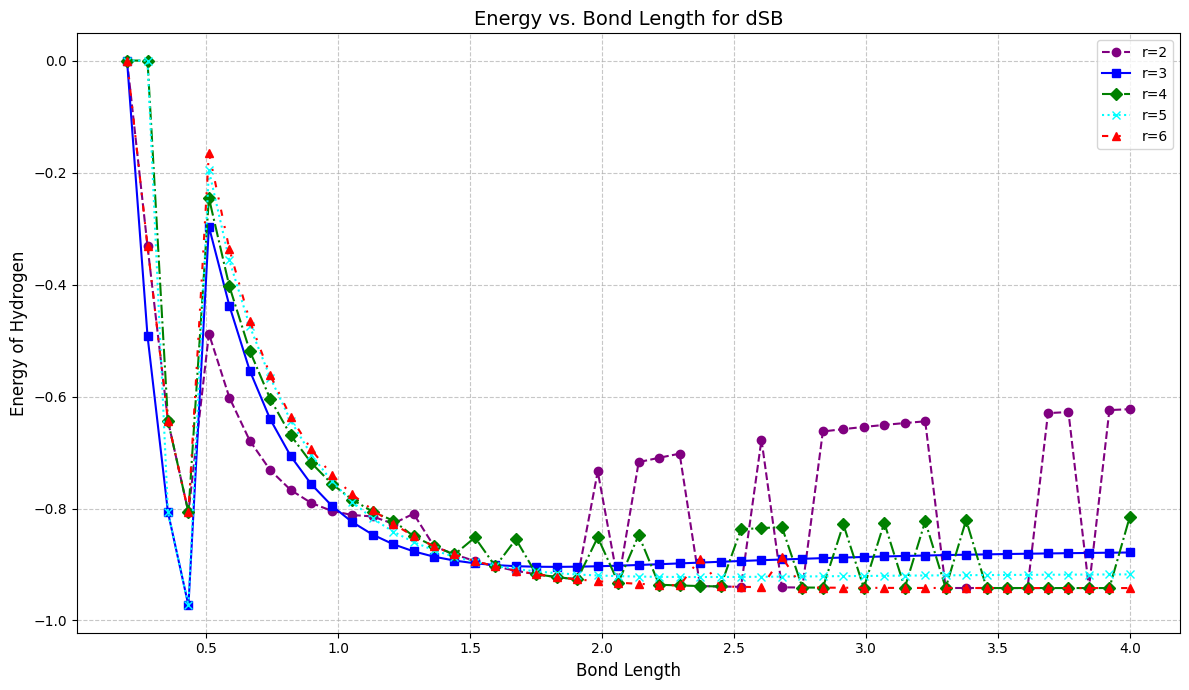

In [11]:
# Define a colormap for better color differentiation
colors = ['purple', 'blue', 'green', 'cyan', 'red']
markers = ['o', 's', 'D', 'x', '^']
linestyles = ['dashed', 'solid', 'dashdot', 'dotted', (0, (3, 5, 1, 5))]  # Added more variations

# Data series
energy_values = [energy2, energy3, energy4, energy5, energy1]
labels = ["r=2", "r=3", "r=4", "r=5", "r=6"]

fig, ax = plt.subplots(figsize=(12, 7))

# Plot each data series
for i, (energy, label) in enumerate(zip(energy_values, labels)):
    ax.plot(bond_lengths, energy, color=colors[i], linewidth=1.5, 
            label=label, marker=markers[i], linestyle=linestyles[i])

# Labels and styling
ax.set_xlabel('Bond Length', fontsize=12)
ax.set_ylabel('Energy of Hydrogen', fontsize=12)
ax.set_title('Energy vs. Bond Length for dSB', fontsize=14)
ax.legend()
ax.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [8]:
np.save("dSBH2r=2", energy2)
np.save("dSBH2r=3", energy3)
np.save("dSBH2r=4", energy4)
np.save("dSBH2r=5", energy5)
np.save("dSBH2r=6", energy1)